# 3 Data Pre-processing


Data pre-processing techniques refer to addition, deletion, or transformation of training set data. Data prepration can make or break a model's preditive ability. The need for data pre-processing is determined by the type of model being used. Some models are less or more sensitive to data. The tree based models are typically insensitive to data and models like linear regressions are not.

The pre-processing techniques discussed in this chapter are focus on **Unsupervised** data models (e.g. PCA) that do not consider the outcome variable in the pre-processing. The **supervised**  methods that do take them into consideration (e.g. partial least squares) the outcome variables will be discussed in later chapters.

*The dataset used to illustrate pre-processing examples is discussed next.*


## 3.1 Case Study: Cell Segmentation in High-Content Screening

To measure the effects of medicines or diseases on the size, shape, development status, and number of cells in living organizm or plant, experts, examines the target serum or tissue under miscroscope and maually assess the desired characteristis. This processes is tedious and a better approach is to use high-contrast screening. 

The high-contrast screening works by measuring the light reflected from a stain that binds to specific characteristic of cell such as cell nuclei. However, this automated method often results in misleading measurements. One such problem is the error in automatic detection of cell boundaries. The researchers assembled a dataset consisting of **2019** cells, where **1300** were judged to be poorly segmented (PS) and **719** were all well segmented (WS). The training/test split of roughly 50% data was used. 

*Lets explore the dataset in little more detail.*

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import glob

%matplotlib inline  

plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True

plt.gray()

In [2]:
datasets = glob.glob('./datasets/segmentationData/*.csv')

In [3]:
datasets

['./datasets/segmentationData/segmentationData.csv']

In [4]:
segData = pd.read_csv(datasets[0])
segData.head()

,Unnamed: 0,Cell,Case,Class,AngleCh1,AreaCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,AvgIntenCh4,...,TotalIntenCh1,TotalIntenCh2,TotalIntenCh3,TotalIntenCh4,VarIntenCh1,VarIntenCh3,VarIntenCh4,WidthCh1,XCentroid,YCentroid
0,1,207827637,Test,PS,143.247705,185,15.711864,4.954802,9.548023,2.214689,...,2781,701.0,1690,392,12.474676,7.609035,2.714100,10.642974,42,14
1,2,207932307,Train,PS,133.752037,819,31.923274,206.878517,69.916880,164.153453,...,24964,160998.0,54675,128368,18.809225,56.715352,118.388139,32.161261,215,347
2,3,207932463,Train,WS,106.646387,431,28.038835,116.315534,63.941748,106.696602,...,11552,47511.0,26344,43959,17.295643,37.671053,49.470524,21.185525,371,252
3,4,207932470,Train,PS,69.150325,298,19.456140,102.294737,28.217544,31.028070,...,5545,28870.0,8042,8843,13.818968,30.005643,24.749537,13.392830,487,295
4,5,207932455,Test,PS,2.887837,285,24.275735,112.415441,20.474265,40.577206,...,6603,30306.0,5569,11037,15.407972,20.504288,45.450457,13.198561,283,159


#### List of predictors 

The researchers used different stains that would be visible to different optical channels. 
* Channel one was associated with the cell body and can be used to determine the cell perimeter, area, and other qualities. 
* Channel two interrogated the cell nucleus by staining the nuclear DNA 
* Channels three and four were stained to detect actin and tubulin, respectively. 



In [5]:
len(list(segData))


62

In [6]:
print (list(segData), end="\n")

['Unnamed: 0', 'Cell', 'Case', 'Class', 'AngleCh1', 'AreaCh1', 'AvgIntenCh1', 'AvgIntenCh2', 'AvgIntenCh3', 'AvgIntenCh4', 'ConvexHullAreaRatioCh1', 'ConvexHullPerimRatioCh1', 'DiffIntenDensityCh1', 'DiffIntenDensityCh3', 'DiffIntenDensityCh4', 'EntropyIntenCh1', 'EntropyIntenCh3', 'EntropyIntenCh4', 'EqCircDiamCh1', 'EqEllipseLWRCh1', 'EqEllipseOblateVolCh1', 'EqEllipseProlateVolCh1', 'EqSphereAreaCh1', 'EqSphereVolCh1', 'FiberAlign2Ch3', 'FiberAlign2Ch4', 'FiberLengthCh1', 'FiberWidthCh1', 'IntenCoocASMCh3', 'IntenCoocASMCh4', 'IntenCoocContrastCh3', 'IntenCoocContrastCh4', 'IntenCoocEntropyCh3', 'IntenCoocEntropyCh4', 'IntenCoocMaxCh3', 'IntenCoocMaxCh4', 'KurtIntenCh1', 'KurtIntenCh3', 'KurtIntenCh4', 'LengthCh1', 'NeighborAvgDistCh1', 'NeighborMinDistCh1', 'NeighborVarDistCh1', 'PerimCh1', 'ShapeBFRCh1', 'ShapeLWRCh1', 'ShapeP2ACh1', 'SkewIntenCh1', 'SkewIntenCh3', 'SkewIntenCh4', 'SpotFiberCountCh3', 'SpotFiberCountCh4', 'TotalIntenCh1', 'TotalIntenCh2', 'TotalIntenCh3', 'TotalIn

In [7]:
segData.describe()

,Unnamed: 0,Cell,AngleCh1,AreaCh1,AvgIntenCh1,AvgIntenCh2,AvgIntenCh3,AvgIntenCh4,ConvexHullAreaRatioCh1,ConvexHullPerimRatioCh1,...,TotalIntenCh1,TotalIntenCh2,TotalIntenCh3,TotalIntenCh4,VarIntenCh1,VarIntenCh3,VarIntenCh4,WidthCh1,XCentroid,YCentroid
count,2019.000000,2.019000e+03,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,...,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000,2019.000000
mean,1010.000000,2.084024e+08,90.493405,320.336305,126.071679,189.052115,96.420171,140.701586,1.205859,0.895764,...,37245.123328,52258.089153,26759.650322,40551.359584,72.197502,98.554872,120.021172,17.623982,260.727093,177.343239
std,582.979416,2.790457e+05,48.760000,214.023533,165.008380,158.956105,96.666921,146.634665,0.202522,0.076108,...,61836.388435,46496.512752,27758.916848,46312.198211,79.690885,96.908200,112.108618,6.166931,140.365593,107.720132
min,1.000000,2.078276e+08,0.030876,150.000000,15.160401,1.000000,0.120000,0.563265,1.005831,0.510623,...,2382.000000,1.000000,24.000000,96.000000,11.466564,0.869253,2.301536,6.393216,9.000000,8.000000
25%,505.500000,2.083325e+08,53.892207,193.000000,35.364158,44.998572,33.495694,40.679739,1.065236,0.856972,...,9499.500000,14367.000000,8776.000000,9939.000000,25.302948,36.704721,47.426963,13.820393,142.000000,88.000000
50%,1010.000000,2.083843e+08,90.588773,253.000000,62.343173,173.506329,67.431250,90.250000,1.148620,0.913262,...,18285.000000,49220.000000,18749.000000,24839.000000,42.500015,69.116555,87.250451,16.187731,262.000000,165.000000
75%,1514.500000,2.084052e+08,126.682013,362.500000,143.187785,279.289699,127.341651,191.170427,1.280514,0.955606,...,35716.500000,72495.000000,35277.000000,55004.000000,81.771899,123.839112,159.136619,19.784021,382.000000,253.000000
max,2019.000000,2.109641e+08,179.939323,2186.000000,1418.634831,989.509804,1205.511538,886.837500,2.900320,0.996499,...,741411.000000,363311.000000,313433.000000,519602.000000,642.024719,757.020963,933.524313,54.744763,501.000000,501.000000


**Class labels**

In [8]:
segData.Class.unique()

array(['PS', 'WS'], dtype=object)

**Training/Testing Split**

In [9]:
segData.groupby('Case')['Case'].count()

Case
Test     1010
Train    1009
Name: Case, dtype: int64

In [10]:
segDataTrain = segData.loc[segData.Case == 'Train']
segDataTest = segData.loc[segData.Case == 'Test']

## 3.2 Data Transformaiton for Individual Predictors

Individual predictors might need transformation for several reasons. The model might require that all predictors adhere to a common scale. The skweness or outliners in the data can also make it harder to build a quality models. Such situation need to be handled before building a model. 

*Next lets look at different type of data transformation involving invidual predictors.*

### Centering and Scaling

Most common form of transformation is to center scale the predictor variables. This is done by simply subtracting the average value of the predictor from all values. This will give the predictor mean of zero. To scale, each predictor is divided by its standard deviation. 

**Pros** : All the data in your model will now have a common scale with zero mean and standard deviation of 1. This offers more numerical stability and 

**Cons**: One downside is that you lose the interpretability of the individual values since that data is no longer in the original units. 

### Transformations to Resolve Skewness

An un-skewed distribution is the one that is roughly symmetric. This means that the probability of falling on either side of the distribution's mean is roughly equal. 

A *right-skewed* distribution has large number of points on the left side of the distribution (smaller values) then on the right side (larger values). Two ways we can get an idea about the skewness in the data.

1. If the ratio of highest to the lowest value is high (> 20), than data have significant skewness. 
2. The skewness statistics can also be used as a diagnostic tool. 

A roughly symmetric distribution will have the skewness value close to zero, right skewed distribution have a large positive value, and for left skewed this value becomes negative. The formula for skewness is given below:

\begin{align}
skewness = \frac{\sum(x_i - \bar{x})^3}{(n-1)v^{\frac{3}{2}}} \\
where \space v = \frac{\sum(x_i - \bar{x})^2}{(n-1)},
\end{align}

where x is the predictor variable, n is the number of values, and $\bar{x}$ is the sample mean of the predictor.

**An example of right skewed data**: The plot below shows a histogram of the standard deviation of the intensity of the pixels in actin filaments (Channel 3). The plot on the left is in natural units, whereas the right plot shows the same data after a log transformation. 

Text(0,0.5,'Count')

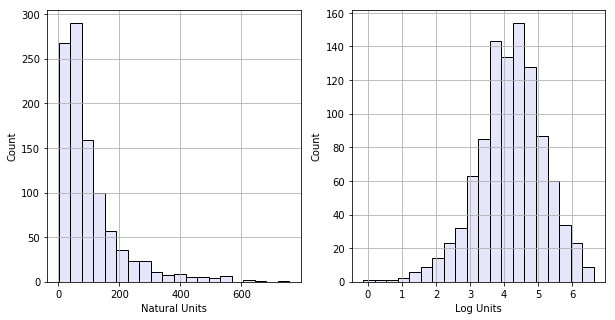

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(segDataTrain.VarIntenCh3.values, bins=20, color='lavender')
ax1.set_xlabel('Natural Units')
ax1.set_ylabel('Count')

ax2.hist(np.log(segDataTrain.VarIntenCh3.values), bins=20, color='lavender')
ax2.set_xlabel('Log Units')
ax2.set_ylabel('Count')

The predictor above has a strong skewnewss with a concentration of points with low values. Here ratio of the smallest to the largest value is 870 with a skewness value of 2.39. The skewness value drops to -0.4 when the same data is logged. 

In [12]:
def skewness(X):
    " Compute the skewness statistics"
    N = X.count()
    mu = np.mean(X)
    v = np.dot(X-mu, X-mu) / (N -1)
    
    return np.sum( (X-mu) **3) / ( (N -1) * v ** (3/2))
    
def ratio_larget_to_smallest(X):
    return max(X) / min(X)

print ("Skewness statistics of natural data ", skewness(segDataTrain.VarIntenCh3))
print ("Ratio of largest to smallest value ", ratio_larget_to_smallest(segDataTrain.VarIntenCh3))
print ("Skewness statistics of log data ", skewness(np.log(segDataTrain.VarIntenCh3)))

Skewness statistics of natural data  2.39399697711
Ratio of largest to smallest value  870.887247203
Skewness statistics of log data  -0.404186963503


**Box-Cox**: A direct method to empirically identify appropriate transformation is propsed by Box and Cox. These trnasformations are indexed by a parameter $\lambda$. The training data is used for estimating the value of $\lambda$ using maximum likelihood estimation. 

\begin{align}
    x^*=
     \begin{cases}
      \frac{x^\lambda -1}{\lambda}, & \text{if}\ \lambda \neq 1 \\
      log(x), & \text{if}\ \lambda = 0
    \end{cases}
\end{align}

In addition to log transformations, the box-cox family can identify square transformations ( $\lambda = 2$), square root ( $\lambda = 0.5$), inverse ( $\lambda = -1$).  

The plot below shows the histogram of cell perimeter predictor. *Left*: plot with natural units. *Right*: the same data after Box-Cox transformation with $\lambda$ estimated to be -1.1. 

Box-Cox lambda value = -1.09128437890813


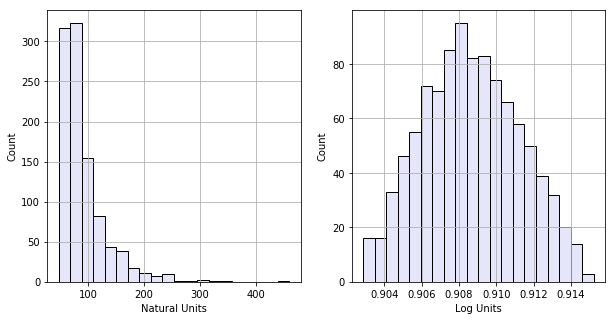

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.hist(segDataTrain.PerimCh1.values, bins=20, color='lavender')
ax1.set_xlabel('Natural Units')
ax1.set_ylabel('Count')

ax2.hist(boxcox(segDataTrain.PerimCh1.values)[0], bins=20, color='lavender')
ax2.set_xlabel('Log Units')
ax2.set_ylabel('Count')

print ("Box-Cox lambda value = {}".format(boxcox(segDataTrain.PerimCh1.values)[1]))

## 3.3 Data Transformations for Multiple Predictors

These transformations act on groups of predictors. 

### Transformations to Resolve Outliers

Outliers are samples that are exceptionally far from the mainstream of the data. Suspected outlier samples need to carefully evaluated to make sure that they are otherwise valid and no data recording errors have occured. Additionaly, the outlying data may be an indication of a special part of the population that is just starting to be sampled. 

Certain **models are resistant to outlier**. Tree based are usually not affected by outliers. Also, support vector machines also ignores portion of the training samples that might be far away from the decision boundary. 


If a model is sensitive to outliers, a **spatial sign** transformation can minimize the problem. It projects the predictor values onto a multidimensional sphere. This has the effect of making all the samples the same distance from the center of the sphere. Mathematiclaly, each sample is divided by its square norm:

\begin{align}
x_{ij}^{*} = \frac{x_{ij}}{\sum_{j=1}^Px_{ij}^2}
\end{align}

It is important to center and scale the predictor data prior to using the spatial sign transformation as the denominator above is intended to measure the square distance to the center of the predictor's distribution. 




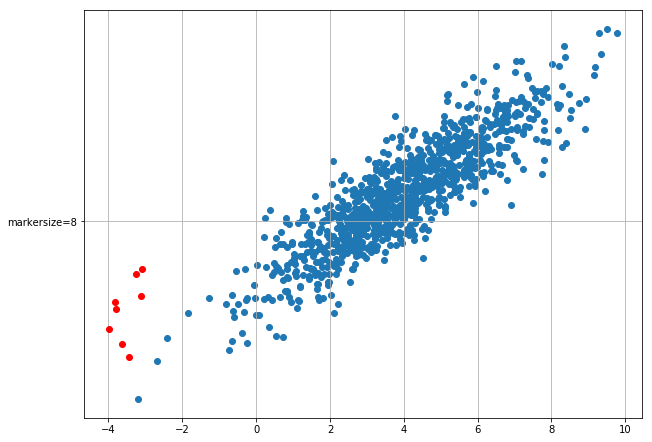

In [26]:
N = 1000
slope, intercept = 0.9, -2.5
X = np.random.normal(4, 2, N)
Y = intercept + (slope * X + np.random.normal(size = N))

X_outliers = np.random.uniform(-4, -3, 8)
Y_outliers = X_outliers + np.random.normal(size = 8)

plt.scatter(X, Y)
plt.plot(X_outliers, Y_outliers, 'ro', 'markersize=8')
plt.show()